### Structured Data: Learning, Prediction, Dependency, Testing

# Implementation: Random Fourier Features 


*Léa Bresson, Eya Kalboussi, Benoit Robaglia*


### Table of contents

[1. Random Fourier Features](#1)<br>
[2. Classification with the USPS dataset](#2)<br>
[3. Classification with the Gisette dataset](#3)<br>



In [3]:
import numpy as np
import pandas as pd
from matplotlib import cm 
from time import time
from matplotlib import pyplot as plt 
%matplotlib inline 
from sklearn.metrics.pairwise import rbf_kernel

<a id='1'></a>
# 1. Random Fourier Features


## 1.1 Implementation

We implement the Random Fourier Features method of the paper *"Random Features for Large-Scale Kernel Machine"*. 
More precisely, the class **RFF_perso** below approximates feature map of an Radial Basis Function (Gaussian) kernel by Monte Carlo approximation of its Fourier transform. The code is from the function RBFSampler from Scikit-learn (the source code is [here](https://github.com/scikit-learn/scikit-learn/blob/a24c8b464d094d2c468a16ea9f8bf8d42d949f84/sklearn/kernel_approximation.py)); we made some minor modifications in order to implement it on our computer (no "*check_is_fitted*", "*check_array*" nor "*check_random_state*"...). In addition, we add the function "**Compute_kernel**" in order to compute the approximate kernel.

More details are given in the report.


In [2]:
from sklearn.base import BaseEstimator
from scipy.stats import cauchy
from sklearn.metrics.pairwise import rbf_kernel

class RFF_perso(BaseEstimator):

    """Approximates feature map of an RBF kernel by Monte Carlo approximation
    of its Fourier transform.
    ----------
    gamma : float
         Parameter of RBF kernel: exp(-gamma * x^2)
    n_components : int
        Number of Monte Carlo samples per original feature.
        Equals the dimensionality of the computed feature space.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    Notes
    -----
    See "Random Features for Large-Scale Kernel Machines" by A. Rahimi and
    Benjamin Recht.
    """
        
    def __init__(self, gamma=1., n_components=100, random_state=None):
        self.gamma = gamma
        self.n_components = n_components
        self.random_state = random_state

        
    def fit(self, X, y=None):
        """Fit the model with X.
        Samples random projection according to n_features.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Training data, where n_samples in the number of samples
            and n_features is the number of features.
        Returns
        -------
        self : object
            Returns the transformer.
        """
        n_features = X.shape[1] 
        self.random_weights_ = (np.sqrt(2 * self.gamma) * np.random.normal(
            size=(n_features, self.n_components)))
        self.random_offset_ = np.random.uniform(0, 2 * np.pi,
                                                   size=self.n_components)
        
        return self
    
    
    def transform(self,X):
        """Apply the approximate feature map to X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            New data, where n_samples in the number of samples
            and n_features is the number of features.
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        projection = X.dot(self.random_weights_)
        projection += self.random_offset_
        np.cos(projection, projection)
        projection *= np.sqrt(2.) / np.sqrt(self.n_components)
        
        return projection
    
    def compute_kernel(self, X):
        """Computes the approximated kernel matrix.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            New data, where n_samples in the number of samples
            and n_features is the number of features.
        Returns
        -------
        K : approximated kernel matrix
        """
        projection = self.transform(X)
        K = projection.dot(projection.T)
        
        return K

## 1.2 Evaluation

Before applying to a real dataset, we evaluate the approximation. The class above takes as inputs gamma and n_components (number of Monte Carlo samples) in order to approximate the kernel. We would like to see how good is the approximation depending on n_components.

#### Kernel approximation quality for varying amounts of Monte Carlo samples

In [3]:
def cosine_similarity(X,Y):
    return(np.trace(X.dot(Y.T))/(np.linalg.norm(X)*np.linalg.norm(Y)))

In [4]:
n_samples, n_features = 5000, 200 
X = np.random.randn(n_samples, n_features)
gamma = 1

In [5]:
time_rbf = time()
K_rbf = rbf_kernel(X, gamma=gamma)
time_rbf_ = time() - time_rbf 

n_components = np.arange(1, 2000, 200)
error_rbf, time_rbf = [], []

In [6]:
for n_c in n_components:
    gauss_time = time()
    gauss = RFF_perso(n_components = n_c)
    gauss.fit(X)
    K_rbf_2 = gauss.compute_kernel(X)
    time_rbf.append(time() - gauss_time)

    error_rbf.append(cosine_similarity(K_rbf_2, K_rbf))

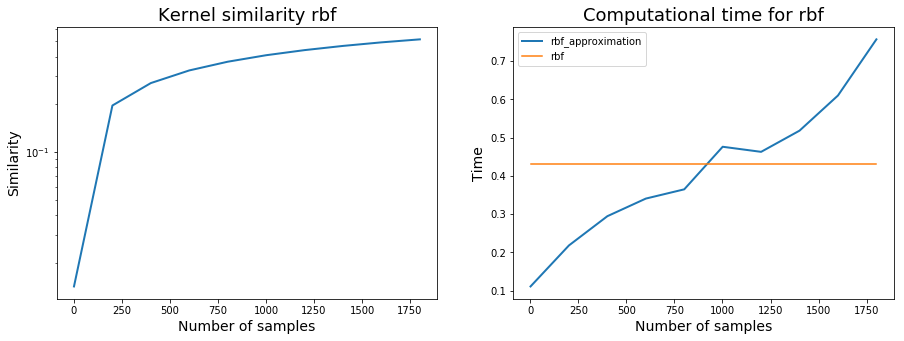

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(n_components, error_rbf, lw=2)
plt.yscale('log')
plt.title("Kernel similarity rbf", fontsize=18)
plt.xlabel("Number of samples", fontsize=14)
plt.ylabel("Similarity", fontsize=14)

plt.subplot(1, 2, 2)

plt.plot(n_components, time_rbf, lw=2, label = 'rbf_approximation')
plt.plot(n_components, [time_rbf_ for i in range(len(n_components))], label = 'rbf')
plt.title("Computational time for rbf", fontsize=18)
plt.xlabel("Number of samples", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.legend()

<a id='2'></a>
# 2. Classification with the USPS dataset 

We test the RBF to perform a SVM classification on the digits dataset. 

In [8]:
from sklearn import datasets, svm
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC

In [64]:
# The digits dataset
digits = fetch_mldata("USPS")
data =digits.data
# To apply an classifier on this data, we need to flatten the image, to turn the data in a (samples, feature) matrix:
n_samples = len(digits.data)
data = digits.data #/ 16.
#data -= data.mean(axis=0)
X = digits.data
y = digits.target
X.shape, y.shape

((9298, 256), (9298,))

In [65]:
split = ShuffleSplit(n_splits=2, test_size=0.2, random_state=123)  
train, test = list(split.split(X))[0]
X_train = X[train].copy()                                  
y_train = y[train].copy()
X_test = X[test].copy()                                    
y_test = y[test].copy() 

In [66]:
X_train.shape, y_train.shape

((7438, 256), (7438,))

## 2.1 First we make sure that our class RBF_perso gives the same results as the RBFSampler function from scikit learn

In [67]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler

In [68]:
gamma = 1/2 
n_components = 200

In [69]:
# Using scikit learn implemented method
rbf_feature = RBFSampler(gamma=gamma, n_components=n_components)
fourier_approx = Pipeline([('std',StandardScaler()),
                           ("feature_map", rbf_feature),
                                        ("svm", svm.LinearSVC())])

kernel_time = time()
fourier_approx.fit(X_train, y_train)
fourier_score = fourier_approx.score(X_test, y_test)
kernel_time = time() - kernel_time

In [70]:
# Using the implemented method above
Gauss = RFF_perso(n_components=n_components, gamma = gamma)
fourier_approx_implemented = Pipeline([('std',StandardScaler()),
                                       ("feature_map", Gauss),
                                        ("svm", svm.LinearSVC())])

kernel_impl_time = time()
fourier_approx_implemented.fit(X_train, y_train)
fourier_impl_score = fourier_approx_implemented.score(X_test, y_test)
kernel_impl_time = time() - kernel_impl_time

The score, as well as the computational time, of the Scikit-learn code and the one implemented above are equivalent.

In [71]:
print('When using the Scikit-learn implemented method: computational time = %f , score = %f'% (
    kernel_time, fourier_score))
print('When using our implemented method: computational time = %f , score = %f'% (
    kernel_impl_time, fourier_impl_score))

When using the Scikit-learn implemented method: computational time = 2.281890 , score = 0.198925
When using our implemented method: computational time = 2.363551 , score = 0.186559


## 2.2 Classification task

We compare the performance (in terms of timing and accuracy) of i) a linear SVM using the approximate mappings and ii) a kernelized (Gaussian) SVM (exact SVM).


In [72]:
gamma = 1/200 # arbitrary choice 
n_components = np.arange(10, 250, 40)
n_components

array([ 10,  50,  90, 130, 170, 210])

### Precision and timing for varying amounts of Monte Carlo samplings

In [73]:
# With our feature map 
score_kernel = []
time_kernel = []
for n_c in n_components:
    Gauss = RFF_perso(n_components = n_c, gamma = gamma)
    fourier_approx_implemented = Pipeline([('std',StandardScaler()),
                                           ("feature_map", Gauss),
                                        ("linsvc", OneVsRestClassifier(LinearSVC(C = 5)))])
    
    
    kernel_time = time()
    fourier_approx_implemented.fit(X_train, y_train)
    y_pred1 = fourier_approx_implemented.predict(X_test)                      
    fourier_score = accuracy_score(y_test, y_pred1)  
    
    kernel_time = time() - kernel_time
    score_kernel.append(fourier_score)
    time_kernel.append(kernel_time)

In [74]:
# Kernelized SVM
svm2 = Pipeline([('std',StandardScaler()),('svm', OneVsRestClassifier(SVC(C=5, kernel="rbf")))])

svm2_time = time()
svm2.fit(X_train, y_train)
y_pred2 = svm2.predict(X_test)                      
svm2_score = accuracy_score(y_test, y_pred2)  
svm2_time = time() - svm2_time

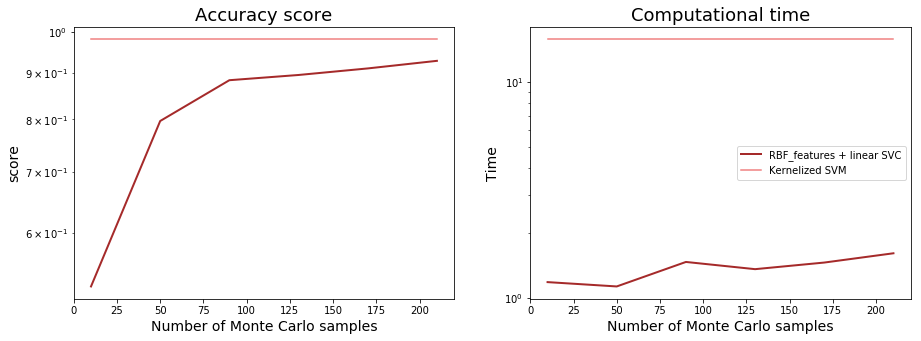

In [75]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(n_components, score_kernel, lw=2, label = 'RBF_features + linear SVC', color = 'brown')
plt.plot(n_components, [svm2_score for i in range(len(n_components))], label = 'Kernelized SVM', color = 'lightcoral')
plt.yscale('log')
plt.title("Accuracy score", fontsize=18)
plt.xlabel("Number of Monte Carlo samples", fontsize=14)
plt.ylabel("score", fontsize=14)

plt.subplot(1, 2, 2)

plt.plot(n_components, time_kernel, lw=2, label = 'RBF_features + linear SVC', color = 'brown')
plt.plot(n_components, [svm2_time for i in range(len(n_components))], label = 'Kernelized SVM', color = 'lightcoral')
plt.yscale('log')
plt.title("Computational time", fontsize=18)
plt.xlabel("Number of Monte Carlo samples", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.legend()

In [76]:
index = np.argmax(score_kernel)
print("\033[1mResults for %s Monte Carlo samples (dimensionality of the computed feature space):\033[0m" % n_c )

print('When using RBF_features + a linear classifier: computation time = %f , score = %f \n' %(
    time_kernel[index], score_kernel[index]))
print('When using a kernelized SVM: computation time = %f , score = %f \n' %(
    svm2_time, svm2_score) ) 

Results for 210 Monte Carlo samples (dimensionality of the computed feature space):
When using RBF_features + a linear classifier: computation time = 1.615343 , score = 0.928495 

When using a kernelized SVM: computation time = 15.781232 , score = 0.980645 



There is a tradeoff between runtime and accuracy, given by the parameter n_components.

### Visualization
Let's compare the classification plots: 

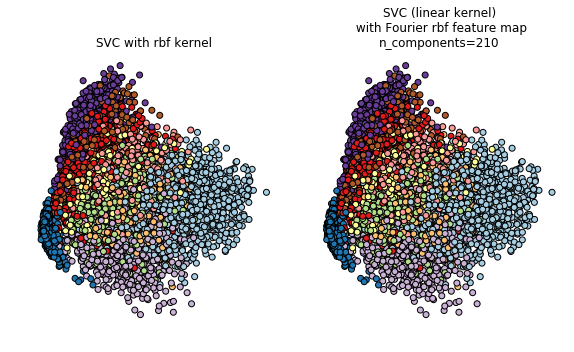

In [77]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8).fit(X_train)
X = pca.transform(X_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first component
first = multiples[:, np.newaxis] * pca.components_[0, :]
# steps along second component
second = multiples[:, np.newaxis] * pca.components_[1, :]
# combine
grid = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=210']
plt.tight_layout()
plt.figure(figsize=(12, 5))

# predict and plot
for i, clf in enumerate((svm2, fourier_approx_implemented)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)

    # Put the result into a color plot
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
plt.tight_layout()
plt.show()

In [78]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred2, y_test)


array([[320,   0,   0,   0,   0,   1,   0,   0,   1,   0],
       [  0, 259,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0, 174,   1,   2,   2,   1,   2,   1,   1],
       [  0,   0,   0, 153,   0,   0,   0,   0,   1,   1],
       [  1,   0,   1,   0, 153,   2,   0,   2,   0,   1],
       [  1,   0,   0,   3,   0, 146,   1,   0,   2,   0],
       [  0,   0,   1,   0,   0,   1, 164,   0,   0,   0],
       [  0,   2,   0,   0,   0,   0,   0, 146,   1,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0, 137,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0, 172]], dtype=int64)

In [7]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(classes)
   # plt.xticks(tick_marks, classes, rotation=45)
   # plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix


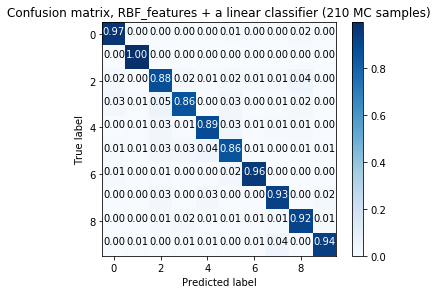

In [80]:
# Compute confusion matrix
cnf_matrix1 = confusion_matrix(y_test, y_pred1)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix1, classes=10,
                      title='Confusion matrix, RBF_features + a linear classifier (210 MC samples)')

We can see that the dataset used is large enough (9298 samples and 256 features) to show the benefits of kernel approximation. Let's try with another dataset that has more features.

<a id='3'></a>
# 3. Classification with the Gisette Dataset

### Test on gisette dataset

The dataset is available here https://archive.ics.uci.edu/ml/datasets/Gisette.

In [153]:
Xg = pd.read_csv("gisette_train.data", sep=' ', header=None)
yg = pd.read_csv("gisette_train.labels",header=None)
valid = pd.read_csv("gisette_valid.data", sep=' ', header=None)
valid_lab = pd.read_csv("gisette_valid.labels",header=None)
del Xg[5000] # Removing the last column which has only NaN
del valid[5000]

In [176]:
print(Xg.shape)
print(yg.shape)
print(valid.shape)
print(valid_lab.shape)

(6000, 5000)
(6000, 1)
(1000, 5000)
(1000, 1)


### Preprocessing

In [83]:
Xg.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,550,0,495,0,0,0,0,976,0,0,...,0,0,0,991,991,0,0,0,0,983
1,0,0,0,0,0,0,0,976,0,0,...,0,475,0,991,0,0,991,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,742,0,0,0,0,684,0,956,...,0,0,0,0,0,0,674,0,0,838
4,0,0,0,0,0,0,0,608,0,979,...,991,0,0,828,0,0,0,0,0,0


In [157]:
sc = StandardScaler()
Xg = sc.fit_transform(Xg)
sc2 = StandardScaler()
valid = sc2.fit_transform(valid)

In [171]:
#Splitting the data into a train and test set
from sklearn.model_selection import train_test_split
train, test, train_lab, test_lab = train_test_split(Xg, yg, test_size=0.33)

In [177]:
print(train.shape)
print(test.shape)

(4020, 5000)
(1980, 5000)


#### Choice of gamma with 5 fold cross validation

In [133]:
Gamma = np.logspace(-6,-1,5)
Gamma

array([1.00e-06, 1.78e-05, 3.16e-04, 5.62e-03, 1.00e-01])

In [166]:
from sklearn.model_selection import cross_val_score
for g in Gamma:
    Gauss = RFF_perso(n_components = n_c, gamma = g)
    fourier_approx_implemented = Pipeline([("feature_map", Gauss),
                                        ("linsvc", OneVsRestClassifier(LinearSVC(C = 6)))])
    c = cross_val_score(fourier_approx_implemented, valid, valid_lab, cv = 5)
    print("Gamma = ", g , "Accuracy = %.2f" %np.mean(c), "(%.4f)" %np.std(c) )

Gamma =  1e-06 Accuracy = 0.93 (0.0226)
Gamma =  1.778279410038923e-05 Accuracy = 0.96 (0.0194)
Gamma =  0.00031622776601683794 Accuracy = 0.92 (0.0139)
Gamma =  0.005623413251903491 Accuracy = 0.50 (0.0132)
Gamma =  0.1 Accuracy = 0.47 (0.0108)


##### Testing on the gisette dataset

In [180]:
gamma = 1.78e-05
n_components = np.arange(10, 5000, 400)
n_components

array([  10,  410,  810, 1210, 1610, 2010, 2410, 2810, 3210, 3610, 4010,
       4410, 4810])

In [181]:
# With our feature map 
score_kernel = []
time_kernel = []
for n_c in n_components:
    Gauss = RFF_perso(n_components = n_c, gamma = gamma)
    fourier_approx_implemented = Pipeline([("feature_map", Gauss),
                                        ("linsvc", OneVsRestClassifier(LinearSVC(C = 6)))])
    
    
    kernel_time = time()
    fourier_approx_implemented.fit(train, train_lab )
    y_pred_gisette = fourier_approx_implemented.predict(test)

    fourier_score = accuracy_score(test_lab, y_pred_gisette)  
    
    kernel_time = time() - kernel_time
    score_kernel.append(fourier_score)
    time_kernel.append(kernel_time)

In [173]:
# Exact SVM
svm2 = Pipeline([('svm', OneVsRestClassifier(SVC(C=6, kernel="rbf")))])

svm2_time = time()
svm2.fit(train, train_lab)
y_pred2 = svm2.predict(test)                      
svm2_score = accuracy_score(test_lab, y_pred2)  
svm2_time = time() - svm2_time

Accuracy score exact RBF kernel SVM :  0.9742424242424242 Computational time : 93.4
Max accuracy score for RFF SVM :  0.9681818181818181 Computational time : 10.1


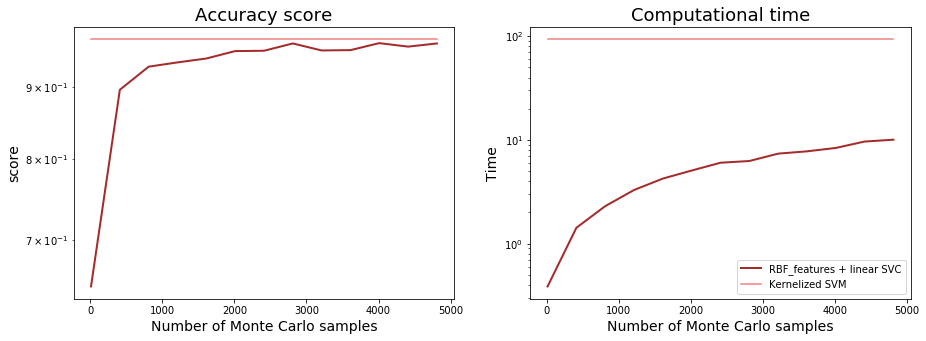

In [182]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(n_components, score_kernel, lw=2, label = 'RBF_features + linear SVC', color = 'brown')
plt.plot(n_components, [svm2_score for i in range(len(n_components))], label = 'Kernelized SVM', color = 'lightcoral')
plt.yscale('log')
plt.title("Accuracy score", fontsize=18)
plt.xlabel("Number of Monte Carlo samples", fontsize=14)
plt.ylabel("score", fontsize=14)

plt.subplot(1, 2, 2)

plt.plot(n_components, time_kernel, lw=2, label = 'RBF_features + linear SVC', color = 'brown')
plt.plot(n_components, [svm2_time for i in range(len(n_components))], label = 'Kernelized SVM', color = 'lightcoral')
plt.yscale('log')
plt.title("Computational time", fontsize=18)
plt.xlabel("Number of Monte Carlo samples", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.legend()

print("Accuracy score exact RBF kernel SVM : ", svm2_score, "Computational time : %.1f" %svm2_time)
print("Max accuracy score for RFF SVM : " , np.max(score_kernel), "Computational time : %.1f" %np.max(time_kernel))

The SVM with a fandom fourier feature kernel approximation can give very similar results to the exact SVM with a computational time 10 times lower.

In [183]:
#Confusion matrix for the RFF + svm with n_components = 5000
matrix = confusion_matrix(y_pred_gisette, test_lab)


array([[943,  23],
       [ 41, 973]], dtype=int64)

Normalized confusion matrix


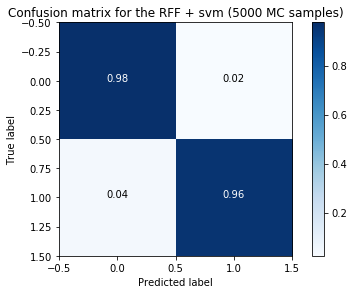

In [9]:
np.set_printoptions(precision=2)

plot_confusion_matrix(matrix, classes=2,
                      title='Confusion matrix for the RFF + svm (5000 MC samples)')